Python interpreter will be restarted.
Python interpreter will be restarted.


All data quality checks passed!
Data saved to Delta Lake!
Latest Crypto Prices:


market_cap,price_usd,symbol,timestamp,volume_24h,price_change_24h
1.3795925729724E11,2.35,XRP,2025-05-24T12:48:41.770+0000,2.59667765469E9,null
1.5272818467184E11,1.0,USDT,2025-05-24T12:48:41.770+0000,8.764379676893E10,null
6.172725034741E10,1.0,USDC,2025-05-24T12:48:41.770+0000,1.163642882258E10,null
2.575183622124E10,0.27,TRX,2025-05-24T12:48:41.770+0000,6.7459832895E8,null
9.180219874738E10,176.44,SOL,2025-05-24T12:48:41.770+0000,5.06003039652E9,null
3.085818475403E11,2556.05,ETH,2025-05-24T12:48:41.770+0000,1.845374891844E10,null
3.410734043714E10,0.23,DOGE,2025-05-24T12:48:41.770+0000,2.03499532554E9,null
2.16138103956056E12,108780.6,BTC,2025-05-24T12:48:41.770+0000,5.927154553861E10,null
9.512226881043E10,675.16,BNB,2025-05-24T12:48:41.770+0000,1.73267910476E9,null
2.683833967236E10,0.76,ADA,2025-05-24T12:48:41.770+0000,9.2557063414E8,null


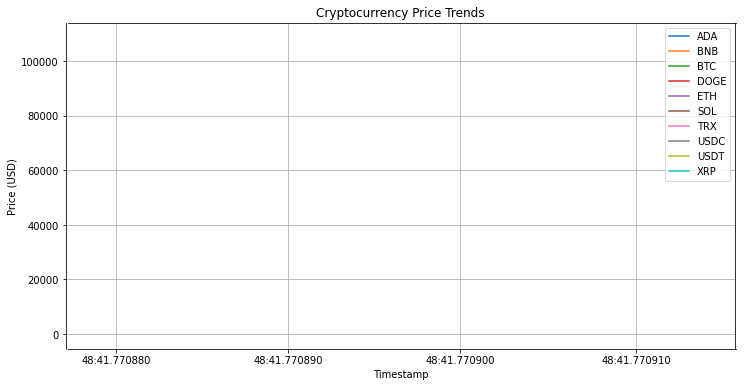

In [0]:
#1. Setup & Configuration

# Install required libraries 
%pip install requests matplotlib

# Import libraries
import requests
from pyspark.sql import SparkSession, functions as F
from pyspark.sql.window import Window
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd

# Configuration 
API_KEY = "ef592ffa-f915-4d43-bdf6-6755b3ffdbef"  
CRYPTO_SYMBOLS = "BTC,ETH,USDT,XRP,BNB,SOL,USDC,DOGE,ADA,TRX"
SAVE_PATH_RAW = "/FileStore/crypto/raw_data"     
SAVE_PATH_PROCESSED = "/FileStore/crypto/processed_data"

#2. Data Ingestion

def fetch_crypto_data():
    """Fetch live data from CoinMarketCap API"""
    url = "https://pro-api.coinmarketcap.com/v1/cryptocurrency/quotes/latest"
    headers = {"X-CMC_PRO_API_KEY": API_KEY}
    params = {"symbol": CRYPTO_SYMBOLS, "convert": "USD"}
    
    try:
        response = requests.get(url, headers=headers, params=params, timeout=10)
        response.raise_for_status()
        return response.json()
    except Exception as e:
        print(f"API Error: {e}")
        return None

#3. Data Transformation

def process_data(raw_data):
    """Clean and transform raw data"""
    spark = SparkSession.builder.getOrCreate()
    
    # Create DataFrame from raw data
    records = []
    for symbol in raw_data["data"]:
        coin = raw_data["data"][symbol]
        records.append({
            "symbol": symbol,
            "timestamp": datetime.now().isoformat(),
            "price_usd": coin["quote"]["USD"]["price"],
            "volume_24h": coin["quote"]["USD"]["volume_24h"],
            "market_cap": coin["quote"]["USD"]["market_cap"]
        })
    
    df = spark.createDataFrame(records)
    
    # Data Cleaning
    df = (df
          .withColumn("timestamp", F.to_timestamp("timestamp"))
          .withColumn("price_usd", F.round("price_usd", 2))
          .withColumn("volume_24h", F.round("volume_24h", 2))
          .withColumn("market_cap", F.round("market_cap", 2))
         )
    
    # Calculate price changes
    window = Window.partitionBy("symbol").orderBy("timestamp")
    df = df.withColumn("price_change_24h", 
                      F.round(F.col("price_usd") - F.lag("price_usd", 1).over(window), 2))
    
    return df

#4. Data Quality Checks

def validate_data(df):
    """Run data quality assertions"""
    # Check for null values
    assert df.filter(F.col("price_usd").isNull()).count() == 0, "Null values in price!"
    
    # Check schema
    expected_cols = {"symbol", "timestamp", "price_usd", "volume_24h", "market_cap", "price_change_24h"}
    assert set(df.columns) == expected_cols, "Schema mismatch!"
    
    print("All data quality checks passed!")

#5. Save to Delta Lake

def save_data(df, mode="append"):
    """Save data to Delta Lake"""
    # Save raw data
    df.write.format("delta").mode(mode).save(SAVE_PATH_RAW)
    
    # Save processed data
    df.write.format("delta").mode("overwrite").save(SAVE_PATH_PROCESSED)
    print("Data saved to Delta Lake!")

#6. Visualization & Analysis

def visualize_data():
    """Generate time-series plot and table"""
    # Read processed data
    df = spark.read.format("delta").load(SAVE_PATH_PROCESSED)
    
    # Display table
    print("Latest Crypto Prices:")
    display(df.orderBy(F.desc("timestamp")))
    
    # Matplotlib plot
    pdf = df.toPandas()
    pdf["timestamp"] = pd.to_datetime(pdf["timestamp"])
    
    plt.figure(figsize=(12, 6))
    for symbol in pdf["symbol"].unique():
        symbol_data = pdf[pdf["symbol"] == symbol]
        plt.plot(symbol_data["timestamp"], symbol_data["price_usd"], label=symbol)
    
    plt.title("Cryptocurrency Price Trends")
    plt.xlabel("Timestamp")
    plt.ylabel("Price (USD)")
    plt.legend()
    plt.grid(True)
    display(plt.show())

#7. Orchestration

raw_data = fetch_crypto_data()

if raw_data:
    processed_df = process_data(raw_data)
    validate_data(processed_df)
    save_data(processed_df)
    visualize_data()
else:
    print("Pipeline failed at ingestion step!")
